# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:


In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/bootstrap"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/bootstrap/2011_04_29_bb8ebe2312e4424a4e40974f0f21dd008064f736.csv',
 'dataset/bootstrap/2011_05_11_b9e28e48a8ef480eff3420896d92b130ae6496a5.csv',
 'dataset/bootstrap/2011_06_30_460a84a926756768976cb0b24489971651475684.csv',
 'dataset/bootstrap/2011_07_29_5eb962faea0ef05392ba9109546d5d9fda07aa43.csv',
 'dataset/bootstrap/2011_08_31_0cb6804b6953d8fce53fcfae065288fd826d1941.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,dex.html,1224
1,/jquery/chili/jquery.chili-2.2.js,704
2,ss/patterns.less,526
3,/jquery/chili/recipes.js,364
4,ss/forms.less,336


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t82,t83,t84,t85,t86,t87,t88,t89,t90,t91
0,dex.html,1224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/jquery/chili/jquery.chili-2.2.js,704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ss/patterns.less,526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/jquery/chili/recipes.js,364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ss/forms.less,336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

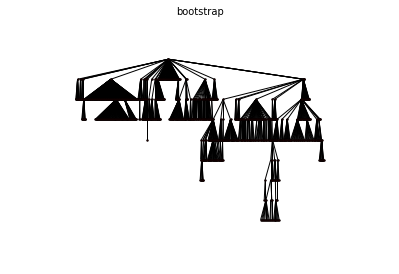

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

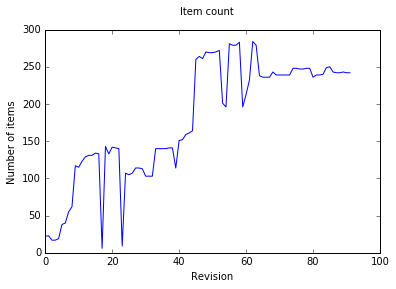

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

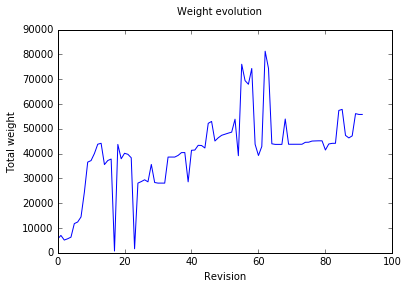

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
0,dex.html,1224.0,NaN,left_only
1,/jquery/chili/jquery.chili-2.2.js,704.0,NaN,left_only
2,ss/patterns.less,526.0,NaN,left_only
3,/jquery/chili/recipes.js,364.0,NaN,left_only
4,ss/forms.less,336.0,NaN,left_only
5,/jquery/hashgrid.js,340.0,NaN,left_only
6,ss/baseline.css,216.0,NaN,left_only
7,ss/type.less,256.0,NaN,left_only
9,ss/docs.less,199.0,NaN,left_only
10,ss/bootstrap.less,201.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
22,cs/index.html,NaN,1177.0,right_only
23,cs/assets/js/jquery/chili/jquery.chili-2.2.js,NaN,704.0,right_only
24,b/patterns.less,NaN,526.0,right_only
25,cs/assets/js/jquery/chili/recipes.js,NaN,364.0,right_only
26,b/forms.less,NaN,336.0,right_only
27,cs/assets/js/jquery/hashgrid.js,NaN,340.0,right_only
28,b/type.less,NaN,256.0,right_only
29,seline-1.0.0.min.css,NaN,196.0,right_only
30,cs/assets/css/docs.css,NaN,203.0,right_only
31,b/bootstrap.less,NaN,211.0,right_only


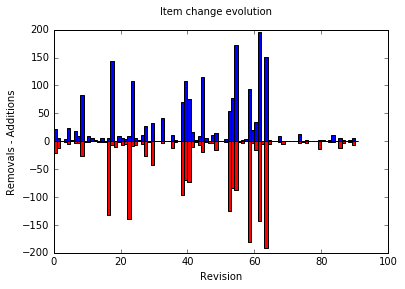

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

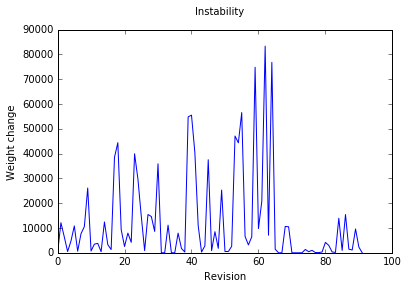

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    